In [48]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [40]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from skimage import filters
from scipy.stats import pearsonr
import momia2 as mo
import plotly.graph_objects as go
import plotly.express as px
from ncolor import label

In [3]:
images = np.load('/Volumes/JZSSD_temp/20221120_NQTF/pred_results/13_0117-0214-1208_clips.npy')
mask = np.load('/Volumes/JZSSD_temp/20221120_NQTF/pred_results/13_0117-0214-1208_omni_masks.npy')
flow = np.load('/Volumes/JZSSD_temp/20221120_NQTF/pred_results/13_0117-0214-1208_omni_flows.npy',allow_pickle=True)

In [4]:
frames = [
    go.Frame(
        data=px.imshow(images[i], aspect="auto", color_continuous_scale="gray", zmin=0,zmax=1, 
        ).data,
        name=i,
    )
    for i in range(len(images))
]
fig = go.Figure(frames=frames)
def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }
sliders = [
            {
                "pad": {"b": 10, "t": 60},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": [
                    {
                        "args": [[f.name], frame_args(0)],
                        "label": str(k),
                        "method": "animate",
                    }
                    for k, f in enumerate(fig.frames)
                ],
            }
        ]

# Layout
fig.update_layout(
         title='Slices in volumetric data',
         width=600,
         height=600,
         scene=dict(aspectratio=dict(x=1, y=1)),
         updatemenus = [
            {
                "buttons": [
                    {
                        "args": [None, frame_args(50)],
                        "label": "&#9654;", # play symbol
                        "method": "animate",
                    },
                    {
                        "args": [[None], frame_args(0)],
                        "label": "&#9724;", # pause symbol
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 70},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
         ],
         sliders=sliders
)
# Add data to be displayed before animation starts
fig.write_html('first_figure.html', auto_open=True)

In [5]:
%matplotlib ipympl

In [46]:
frames=[]
for i in range(18,90):
    p=mo.Patch()
    p.load_data(i,{'C1':images[i]},
                    ref_channel='C1')
    labeled_mask = mask[i]
    p.mask = labeled_mask>0
    p.labeled_mask = labeled_mask
    h,w = labeled_mask.shape
    prob_mask = np.zeros([h,w,3])
    prob_mask[:,:,2] = flow[i][2]
    prob_mask[:,:,0] = 1-p.mask
    prob_mask[:,:,1] = filters.sobel(images[i,1])
    p.prob_mask = prob_mask
    p.locate_particles(precompute_contours=True)
    p.extract_midlines(contour_key='$contours')
    frames.append(p)


tracker_msm = mo.core.CellTracker(frames,np.arange(len(frames)),
                              None,
                              verbose=False,
                              seed_prob_min=0.35,
                              edge_prob_max=0.90,
                              backtrack_generations=2,
                              max_iter=1,
                              min_cell_size=100,
                              min_overlap_area=80,
                              min_overlap_threshold=0.3,
                              min_size_similarity=0.7,
                              no_split=False,hard_split=True)
last_area = None
tracker_msm.trace_by_overlap()
tracker_msm.trace_lineage()

TypeError: extract_midlines() got an unexpected keyword argument 'contour_key'

0

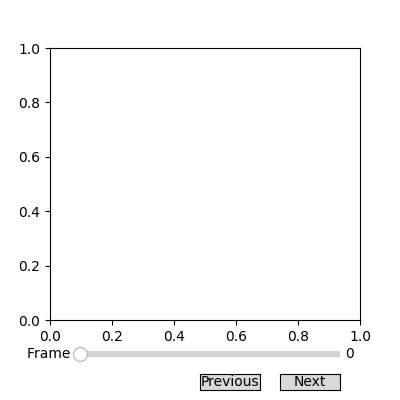

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider, Button
fig, ax = plt.subplots(figsize=(4,4))
fig.subplots_adjust(bottom=0.2)

axframe = fig.add_axes([0.2, 0.1, 0.65, 0.03])

frame_slider = Slider(
    ax=axframe,
    label='Frame ',
    valmin=0,
    valmax=len(images)-1,
    valinit=0,
    valstep=1
)

def update(val):
    ax.imshow(label(mask[int(frame_slider.val)]))
    fig.canvas.draw_idle()
    
forward_ax = fig.add_axes([0.7, 0.025, 0.15, 0.04])
backward_ax = fig.add_axes([0.5, 0.025, 0.15, 0.04])
button1 = Button(forward_ax, 'Next', hovercolor='0.975')
button2 = Button(backward_ax, 'Previous', hovercolor='0.975')


def forward(event):
    frame_slider.set_val(frame_slider.val+1)
    update(frame_slider.val)
    
def backward(event):
    frame_slider.set_val(frame_slider.val-1)
    update(frame_slider.val)
    
    
button1.on_clicked(forward)
button2.on_clicked(backward)
frame_slider.on_changed(update)

In [37]:
help(Slider)

Help on class Slider in module matplotlib.widgets:

class Slider(SliderBase)
 |  Slider(ax, label, valmin, valmax, valinit=0.5, valfmt=None, closedmin=True, closedmax=True, slidermin=None, slidermax=None, dragging=True, valstep=None, orientation='horizontal', *, initcolor='r', track_color='lightgrey', handle_style=None, **kwargs)
 |  
 |  A slider representing a floating point range.
 |  
 |  Create a slider from *valmin* to *valmax* in Axes *ax*. For the slider to
 |  remain responsive you must maintain a reference to it. Call
 |  :meth:`on_changed` to connect to the slider event.
 |  
 |  Attributes
 |  ----------
 |  val : float
 |      Slider value.
 |  
 |  Method resolution order:
 |      Slider
 |      SliderBase
 |      AxesWidget
 |      Widget
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, ax, label, valmin, valmax, valinit=0.5, valfmt=None, closedmin=True, closedmax=True, slidermin=None, slidermax=None, dragging=True, valstep=None, orientation

In [15]:
!pip install jupyterlab_widgets

  Using cached jupyterlab_widgets-3.0.5-py3-none-any.whl (384 kB)


In [ ]:
!pip uninstall jupyterlab_widgets

Found existing installation: jupyterlab-widgets 1.1.1
Uninstalling jupyterlab-widgets-1.1.1:
  Would remove:
    /Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages/jupyterlab_widgets-1.1.1.dist-info/*
    /Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages/jupyterlab_widgets/*
    /Users/jz-rolling/opt/anaconda3/envs/keras_pilot/share/jupyter/labextensions/@jupyter-widgets/jupyterlab-manager/install.json
    /Users/jz-rolling/opt/anaconda3/envs/keras_pilot/share/jupyter/labextensions/@jupyter-widgets/jupyterlab-manager/package.json
    /Users/jz-rolling/opt/anaconda3/envs/keras_pilot/share/jupyter/labextensions/@jupyter-widgets/jupyterlab-manager/schemas/@jupyter-widgets/jupyterlab-manager/package.json.orig
    /Users/jz-rolling/opt/anaconda3/envs/keras_pilot/share/jupyter/labextensions/@jupyter-widgets/jupyterlab-manager/schemas/@jupyter-widgets/jupyterlab-manager/plugin.json
    /Users/jz-rolling/opt/anaconda3/envs/keras_pilot/share/

In [ ]:
!y

/bin/bash: y: command not found
